# Import

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,516 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121918 files and dire

In [4]:
!pip install wordcloud

In [5]:
import matplotlib.pyplot as plt # 맷플롯립 import 하기
plt.rcParams['font.family'] = 'NanumBarunGothic' # 나눔바른고딕 적용하기

In [6]:
# Reading Dataset
import numpy as np
import pandas as pd
# Visualization
import plotly.express as px
import plotly.graph_objects as go  # for 3D plot visualization
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from datetime import datetime

### random seed 고정

In [7]:
import random, os
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## drive 마운트

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 경로 지정

In [9]:
%cd /content/drive/MyDrive/Colab Notebooks/kaggle/animation-recommendation_system/data
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/kaggle/animation-recommendation_system/data')
print(sys.path)
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

/content/drive/MyDrive/Colab Notebooks/kaggle/animation-recommendation_system/data
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/Colab Notebooks/kaggle/animation-recommendation_system/data']
[]


In [10]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.51.34.82:8470
REPLICAS:  8


# Load Data

In [11]:
# # Importing anime details dataframe
# df_rating=pd.read_csv('./animelist.csv')
# print("Shape of the Dataset:",df_rating.shape)
# df_rating.head(3)

In [12]:
# Importing anime details dataframe
rating_df=pd.read_csv('./rating_complete.csv')
print("Shape of the Dataset:",rating_df.shape)
rating_df.head(3)

Shape of the Dataset: (57633278, 3)


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7


# 협업 필터링

Collaborative Filtering¶


* 다른 사용자와의 유사성을 기반으로 사용자가 좋아할 만한 것을 예측합니다.
* 장점: 아이템 자체에 대한 "이해" 없이 영화와 같은 복잡한 아이템을 정확하게 추천할 수 있습니다.
* 추천 시스템에서 측정(사용자 유사도 또는 항목 유사도)에 많이 사용되었습니다.

## 모델링 전 작업

### 모델링 전 정규화

In [13]:
# Scaling BTW (0 , 1.0)
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values.astype(np.float64)

AvgRating = np.mean(rating_df['rating'])
print('Avg', AvgRating)

Avg 0.7234209702402971


### 중복행 확인

In [14]:
rating_df.duplicated().sum()

0

In [15]:
g = rating_df.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = rating_df.groupby('anime_id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')

pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)

anime_id,20,199,226,1535,1575,2904,4224,5114,6547,8074,9253,10620,11757,16498,19815,20507,22319,30276,31964,32281
user_id,,,,,,,,,,,,,,,,,,,,
10255,0.888889,0.888889,0.777778,0.777778,0.777778,0.888889,0.777778,1.000000,0.666667,0.222222,1.000000,0.555556,NaN,0.777778,0.444444,0.555556,NaN,0.333333,0.444444,0.555556
64807,0.555556,1.000000,0.666667,0.666667,1.000000,1.000000,0.666667,0.888889,0.666667,0.888889,0.444444,0.444444,0.000000,0.777778,0.777778,0.777778,0.222222,0.888889,0.777778,1.000000
68042,0.888889,0.777778,0.777778,1.000000,0.888889,0.777778,0.888889,0.888889,0.666667,0.222222,0.888889,0.333333,0.333333,0.888889,0.222222,0.111111,0.444444,0.888889,0.777778,0.888889
85106,0.444444,0.888889,0.777778,0.888889,0.888889,1.000000,0.888889,1.000000,0.777778,0.555556,1.000000,0.666667,0.555556,1.000000,0.888889,0.666667,0.333333,1.000000,0.777778,1.000000
122341,NaN,0.777778,0.111111,0.222222,0.111111,0.111111,0.222222,0.777778,0.444444,0.000000,0.666667,0.111111,0.000000,0.000000,0.333333,0.333333,0.111111,0.555556,0.222222,0.111111
162615,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
182280,0.666667,NaN,0.777778,0.888889,0.777778,0.555556,NaN,1.000000,0.666667,0.666667,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556,0.777778
189037,0.666667,0.666667,0.777778,0.888889,0.666667,0.666667,0.888889,0.777778,1.000000,0.666667,1.000000,0.777778,0.666667,0.555556,0.666667,0.666667,0.666667,0.777778,0.666667,0.666667
190748,0.222222,0.777778,0.555556,0.555556,0.222222,0.222222,0.333333,0.777778,0.666667,0.222222,0.555556,0.333333,0.000000,0.555556,0.222222,0.111111,NaN,0.222222,NaN,NaN


### 범주형 변수 인코딩

In [16]:
# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))

Num of users: 310059, Num of animes: 16872
Min rating: 0.0, Max rating: 1.0


범주형 변수인 user_id와 anim_id를 수치형 변수로 각각 인코딩함



### 종속, 독립 변수 나누기

In [ ]:
# Shuffle
rating_df = rating_df.sample(frac=1, random_state=73)

X = rating_df[['user', 'anime']].values
y = rating_df["rating"]

리뷰 데이터라 특정 사용자 리뷰가 한 곳에 몰릴 수 있기에 섞음

### train 데이터와 test 데이터로 나누기

In [ ]:
# Split
test_set_size = 10000
train_indices = rating_df.shape[0] - test_set_size

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))

> Train set ratings: 57623278
> Test set ratings: 10000


In [ ]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## 모델링

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
TPU_INIT = True

if TPU_INIT:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    !nvidia-smi

print(tf.__version__)

2.12.0


* TPU_INIT = True: TPU를 사용할지 여부를 설정하는 플래그입니다.
* if TPU_INIT: TPU 사용 여부에 따라 분기합니다.
* tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(): TPU 클러스터에 연결합니다.
* tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu): TPU 전략을 설정합니다.
* else: TPU를 사용하지 않을 경우, GPU 사용 여부를 확인합니다.
* !nvidia-smi: NVIDIA GPU의 상태를 확인하는 명령어로, 주피터 노트북에서 셸 명령어를 실행할 때 사용합니다.

### 입력 데이터 임베딩 및 모델층 설계

In [ ]:
# Embedding layers
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def RecommenderNet():
    embedding_size = 128

    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users,
                       output_dim = embedding_size)(user)

    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes,
                       output_dim = embedding_size)(anime)

    #x = Concatenate()([user_embedding, anime_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')

    return model

if TPU_INIT:
    with tpu_strategy.scope():
        model = RecommenderNet()
else:
    model = RecommenderNet()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       39687552    ['user[0][0]']                   
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2159616     ['anime[0][0]']                  
                                                                                            

###call back 함수 정의

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss',
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,
]

모델 학습

In [ ]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
721/721 [==============================] - 43s 46ms/step - loss: 0.6938 - mae: 0.2558 - mse: 0.0858 - val_loss: 0.6903 - val_mae: 0.2538 - val_mse: 0.0843 - lr: 1.0000e-05
Epoch 2/20
721/721 [==============================] - 28s 38ms/step - loss: 0.6851 - mae: 0.2490 - mse: 0.0815 - val_loss: 0.6613 - val_mae: 0.2264 - val_mse: 0.0699 - lr: 8.8000e-05
Epoch 3/20
721/721 [==============================] - 26s 36ms/step - loss: 0.6672 - mae: 0.2320 - mse: 0.0725 - val_loss: 0.6224 - val_mae: 0.1886 - val_mse: 0.0508 - lr: 1.6600e-04
Epoch 4/20
721/721 [==============================] - 26s 36ms/step - loss: 0.6149 - mae: 0.1879 - mse: 0.0480 - val_loss: 0.5677 - val_mae: 0.1352 - val_mse: 0.0271 - lr: 2.4400e-04
Epoch 5/20
721/721 [==============================] - 27s 38ms/step - loss: 0.5786 - mae: 0.1505 - mse: 0.0318 - val_loss: 0.5519 - val_mae: 0.1146 - val_mse: 0.0207 - lr: 3.2200e-04
Epoch 6/20
721/721 [==============================] - 26s 37ms/step - loss: 0.5547 - 

### 학습 결과 시각화

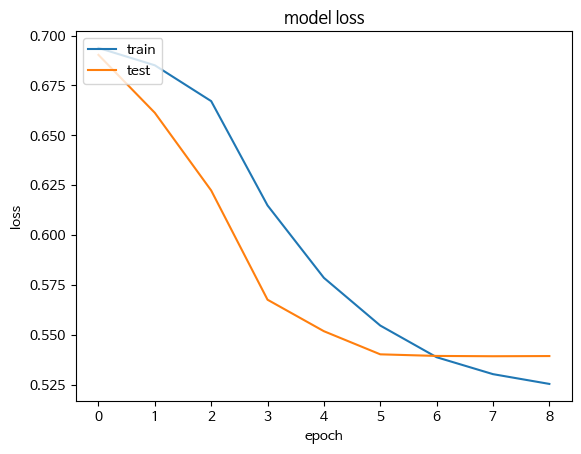

In [ ]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### 학습 가중치 추출

In [17]:
model =tf.keras.models.load_model('./anime_model.h5')

In [18]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

## 메타 데이터 가져오기

In [19]:
df_anime = pd.read_csv('./anime.csv', low_memory=True)
df_anime = df_anime.replace("Unknown", np.nan)
print("Shape of the Dataset:",df_anime.shape)
df_anime.head(5)

Shape of the Dataset: (17562, 35)


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


### 이름 맞추고 데이터 수정

In [20]:
# Fixing Names
def getAnimeName(anime_id):
    try:
        name = df_anime[df_anime.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df_anime[df_anime.anime_id == anime_id].Name.values[0]
    except:
        print('error')

    return name

df_anime['anime_id'] = df_anime['MAL_ID']
df_anime["eng_version"] = df_anime['English name']
df_anime['eng_version'] = df_anime.anime_id.apply(lambda x: getAnimeName(x))

df_anime.sort_values(by=['Score'],
               inplace=True,
               ascending=False,
               kind='quicksort',
               na_position='last')

df_anime = df_anime[["anime_id", "eng_version",
         "Score", "Genres", "Episodes",
         "Type", "Premiered", "Members"]]

In [21]:
def getAnimeFrame(anime):
    if isinstance(anime, int):
        return df_anime[df_anime.anime_id == anime]
    if isinstance(anime, str):
        return df_anime[df_anime.eng_version == anime]

### 시놉시스 데이터 가져오기

In [22]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]
sypnopsis_df = pd.read_csv('./anime_with_synopsis.csv', usecols=cols)

def getSypnopsis(anime):
    if isinstance(anime, int):
        return sypnopsis_df[sypnopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return sypnopsis_df[sypnopsis_df.Name == anime].sypnopsis.values[0]

## Item 기반 추천

In [23]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_animes(name, n=10, return_dist=False, neg=False):
    # try except문을 통해 try문속 오류, false가 뜨면 except문으로 가서 예외를 처리해줌
    try:
        # getAnimeFrame 함수를 사용하여 입력한 애니메이션 제목에 대응하는 anime_id를 얻고, 이를 anime2anime_encoded 딕셔너리를 통해 인코딩된 인덱스로 변환하여 저장
        index = getAnimeFrame(name).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        #애니메이션 임베딩 벡터의 가중치 데이터 가져오기
        weights = anime_weights

        #전체 애니메이션과 입력한 애니메이션과의 유사도를 내적으로 비교하는 행렬 생성
        dists = np.dot(weights, weights[encoded_index])

        #argsort로 정렬가능하게 변경
        sorted_dists = np.argsort(dists)

        #n+1인 이유: 추천할 n개의 애니메이션에 자기 자신도 뜨기때문에 1개 더 추천함
        n = n + 1

        #neg의 인자값에 따라 가장 유사한 걸 추천할지, 가장 유사하지 않은 걸 추천할지 정해짐
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        # return_dist의 인자값이 True면 입력한 애니메이션과 전체 애니메이션과의 유사도 행렬 dists와 추천할 n+1개의 애니메이션 closest를 반환함
        if return_dist:
            return dists, closest

        #애니메이션 df가져옴
        rindex = df_anime

        #결과 반환할 유사한 애니메이션 배열 선언
        SimilarityArr = []

        #추천할 n+1개의 애니메이션을 하나씩 for문에 돌림
        for close in closest:

            #추천할 애니메이션에 대한 정보를 추천 결과에 넣기 위해 인코딩된 인덱스에서 anime_encoded2anime 딕셔너리를 통해 디코딩하여 원래의 애니메이션_id로 변환
            decoded_id = anime_encoded2anime.get(close)

            #변환한 id로 시놉시스 데이터 가져오기
            sypnopsis = getSypnopsis(decoded_id)

            #변환한 id로 애니메이션 df의 해당하는 id 행 가져오기
            anime_frame = getAnimeFrame(decoded_id)

            #그 행의 영문명 가져옴
            anime_name = anime_frame.eng_version.values[0]

            #그 행의 장르 가져옴
            genre = anime_frame.Genres.values[0]

            # 입력 애니와 해당 애니와의 유사도 가져오기
            similarity = dists[close]

            # 배열에 추가
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  'sypnopsis': sypnopsis})

        #유사도를 기준으로 추천 애니메이션 정렬
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)

        # 입력한 애니메이션은 빼고 anime_id열은 삭제
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        #입력한 애니가 없거나 오류 발생시 출력
        print('{}!, Not Found in Anime list'.format(name))

1. 함수 정의 및 이름을 기반으로 한 임베딩 벡터 위치 찾기
2. 애니메이션에 대해서 리뷰를 기반으로 나온 가중치로 서로의 내적을 통해 유사도를 구함
3. 입력한 애니메이션과 유사한 애니메이션 찾기
4. 유사한 애니메이션 추려서 결과로 반환

In [24]:
find_similar_animes('Sword Art Online', n=5, neg=False)

animes closest to Sword Art Online


,name,similarity,genre,sypnopsis
4,Sword Art Online II,0.898467,"Action, Game, Adventure, Romance, Fantasy","ar after escaping Sword Art Online, Kazuto Kirigaya has been settling back into the real world. However, his peace is short-lived as a new incident occurs in a game called Gun Gale Online, where a player by the name of Death Gun appears to be killing people in the real world by shooting them in-game. Approached by officials to assist in investigating the murders, Kazuto assumes his persona of Kirito once again and logs into Gun Gale Online, intent on stopping the killer. Once inside, Kirito meets Sinon, a highly skilled sniper afflicted by a traumatic past. She is soon dragged in his chase after Death Gun, and together they enter the Bullet of Bullets, a tournament where their target is sure to appear. Uncertain of Death Gun's real powers, Kirito and Sinon race to stop him before he has the chance to claim another life. Not everything goes smoothly, however, as scars from the past impede their progress. In a high-stakes game where the next victim could easily be one of them, Kirito puts his life on the line in the virtual world once more."
3,Sword Art Online the Movie -Ordinal Scale-,0.776302,"Action, Game, Adventure, Romance, Fantasy","In 2026, four years after the infamous Sword Art Online incident, a revolutionary new form of technology has emerged: the Augma, a device that utilizes an Augmented Reality system. Unlike the Virtual Reality of the NerveGear and the Amusphere, it is perfectly safe and allows players to use it while they are conscious, creating an instant hit on the market. The most popular application for the Augma is the game Ordinal Scale, which immerses players in a fantasy role-playing game with player rankings and rewards. Following the new craze, Kirito's friends dive into the game, and despite his reservations about the system, Kirito eventually joins them. While at first it appears to be just fun and games, they soon find out that the game is not all that it seems..."
2,Sword Art Online:Extra Edition,0.770487,"Action, Adventure, Fantasy, Game, Romance","The story is set a couple of years after the events of Sword Art Online , where Kazuto ""Kirito"" Kirigaya and his sister Suguha meet up with Asuna Yuuki, Rika ""Lisbeth"" Shinozaki, and Keiko ""Silica"" Ayano at the SAO Survivor School. Kirito then attends emergency counseling, while the girls go for a swim at the pool. It turns out that said ""emergency counseling"" is a subterfuge set up by Seijirou Kikuoka, aiming to rehash the incident of Sword Art Online in hopes of determining Akihiko Kayaba's motives. What will the girls get up to in the pool, and what awaits Kirito and his ""counseling""?"
1,Fairy Tail,0.665175,"Action, Adventure, Comedy, Magic, Fantasy, Shounen","In the mystical land of Fiore, magic exists as an essential part of everyday life. Countless magic guilds lie at the core of all magical activity, and serve as venues for like-minded mages to band together and take on job requests. Among them, Fairy Tail stands out from the rest as a place of strength, spirit, and family. Lucy Heartfilia is a young mage searching for celestial gate keys, and her dream is to become a full-fledged wizard by joining this famous guild. In her search, she runs into Natsu Dragneel and his partner Happy, who are on a quest to find Natsu's foster father, the dragon Igneel. Upon being tricked by a man, Lucy falls under an abduction attempt, only to be saved by Natsu. To her shock, he reveals that he is a member of Fairy Tail and invites her to join them. There, Lucy meets the guild's strange members, such as the ice wizard Gray Fullbuster and magic swordswoman Erza Scarlet. Together as a family, they battle the forces of evil, help those in need, and gain new friends, all the while enjoying the never-ending adventure that is Fairy Tail."
0,Fairy Tail Series 2,0.627079,"Action, Adventure, Comedy, Fantasy, Magic, Shounen","The Grand Magic Games reaches its

In [25]:
find_similar_animes(11757, n=5, neg=False)

animes closest to 11757


,name,similarity,genre,sypnopsis
4,Sword Art Online II,0.898467,"Action, Game, Adventure, Romance, Fantasy","ar after escaping Sword Art Online, Kazuto Kirigaya has been settling back into the real world. However, his peace is short-lived as a new incident occurs in a game called Gun Gale Online, where a player by the name of Death Gun appears to be killing people in the real world by shooting them in-game. Approached by officials to assist in investigating the murders, Kazuto assumes his persona of Kirito once again and logs into Gun Gale Online, intent on stopping the killer. Once inside, Kirito meets Sinon, a highly skilled sniper afflicted by a traumatic past. She is soon dragged in his chase after Death Gun, and together they enter the Bullet of Bullets, a tournament where their target is sure to appear. Uncertain of Death Gun's real powers, Kirito and Sinon race to stop him before he has the chance to claim another life. Not everything goes smoothly, however, as scars from the past impede their progress. In a high-stakes game where the next victim could easily be one of them, Kirito puts his life on the line in the virtual world once more."
3,Sword Art Online the Movie -Ordinal Scale-,0.776302,"Action, Game, Adventure, Romance, Fantasy","In 2026, four years after the infamous Sword Art Online incident, a revolutionary new form of technology has emerged: the Augma, a device that utilizes an Augmented Reality system. Unlike the Virtual Reality of the NerveGear and the Amusphere, it is perfectly safe and allows players to use it while they are conscious, creating an instant hit on the market. The most popular application for the Augma is the game Ordinal Scale, which immerses players in a fantasy role-playing game with player rankings and rewards. Following the new craze, Kirito's friends dive into the game, and despite his reservations about the system, Kirito eventually joins them. While at first it appears to be just fun and games, they soon find out that the game is not all that it seems..."
2,Sword Art Online:Extra Edition,0.770487,"Action, Adventure, Fantasy, Game, Romance","The story is set a couple of years after the events of Sword Art Online , where Kazuto ""Kirito"" Kirigaya and his sister Suguha meet up with Asuna Yuuki, Rika ""Lisbeth"" Shinozaki, and Keiko ""Silica"" Ayano at the SAO Survivor School. Kirito then attends emergency counseling, while the girls go for a swim at the pool. It turns out that said ""emergency counseling"" is a subterfuge set up by Seijirou Kikuoka, aiming to rehash the incident of Sword Art Online in hopes of determining Akihiko Kayaba's motives. What will the girls get up to in the pool, and what awaits Kirito and his ""counseling""?"
1,Fairy Tail,0.665175,"Action, Adventure, Comedy, Magic, Fantasy, Shounen","In the mystical land of Fiore, magic exists as an essential part of everyday life. Countless magic guilds lie at the core of all magical activity, and serve as venues for like-minded mages to band together and take on job requests. Among them, Fairy Tail stands out from the rest as a place of strength, spirit, and family. Lucy Heartfilia is a young mage searching for celestial gate keys, and her dream is to become a full-fledged wizard by joining this famous guild. In her search, she runs into Natsu Dragneel and his partner Happy, who are on a quest to find Natsu's foster father, the dragon Igneel. Upon being tricked by a man, Lucy falls under an abduction attempt, only to be saved by Natsu. To her shock, he reveals that he is a member of Fairy Tail and invites her to join them. There, Lucy meets the guild's strange members, such as the ice wizard Gray Fullbuster and magic swordswoman Erza Scarlet. Together as a family, they battle the forces of evil, help those in need, and gain new friends, all the while enjoying the never-ending adventure that is Fairy Tail."
0,Fairy Tail Series 2,0.627079,"Action, Adventure, Comedy, Fantasy, Magic, Shounen","The Grand Magic Games reaches its

In [26]:
find_similar_animes('Death Note', n=5, neg=False)

animes closest to Death Note


,name,similarity,genre,sypnopsis
4,Code Geass:Lelouch of the Rebellion R2,0.747831,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
3,Code Geass:Lelouch of the Rebellion,0.732480,"Action, Military, Sci-Fi, Super Power, Drama, Mecha, School","In the year 2010, the Holy Empire of Britannia is establishing itself as a dominant military nation, starting with the conquest of Japan. Renamed to Area 11 after its swift defeat, Japan has seen significant resistance against these tyrants in an attempt to regain independence. Lelouch Lamperouge, a Britannian student, unfortunately finds himself caught in a crossfire between the Britannian and the Area 11 rebel armed forces. He is able to escape, however, thanks to the timely appearance of a mysterious girl named C.C., who bestows upon him Geass, the ""Power of Kings."" Realizing the vast potential of his newfound ""power of absolute obedience,"" Lelouch embarks upon a perilous journey as the masked vigilante known as Zero, leading a merciless onslaught against Britannia in order to get revenge once and for all."
2,Fullmetal Alchemist:Brotherhood,0.694283,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen","""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their original bodies that gives Edward the inspiration to obtain metal limbs called ""automail"" and become a state alchemist, the Fullmetal Alchemist. Three years of searching later, the brothers seek the Philosopher's Stone, a mythical relic that allows an alchemist to overcome the Law of Equivalent Exchange. Even with military allies Colonel Roy Mustang, Lieutenant Riza Hawkeye, and Lieutenant Colonel Maes Hughes on their side, the brothers find themselves caught up in a nationwide conspiracy that leads them not only to the true nature of the elusive Philosopher's Stone, but their country's murky history as well. In between finding a serial killer and racing against time, Edward and Alphonse must ask themselves if what they are doing will make them human again... or take away their humanity."
1,Attack on Titan,0.685682,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered 

### 영화 3개받고 5개 추천

In [27]:
def find_similar_animes_combined(anime_names, n=3, return_dist=False, neg=False):
    try:
        encoded_indices = []
        input_anime_ids = []
        for name in anime_names:
            index = getAnimeFrame(name).anime_id.values[0]
            input_anime_ids.append(index)
            encoded_index = anime2anime_encoded.get(index)
            encoded_indices.append(encoded_index)

        # Combine embeddings
        combined_weights = np.mean(anime_weights[encoded_indices], axis=0)
        combined_weights = combined_weights / np.linalg.norm(combined_weights)

        dists = np.dot(anime_weights, combined_weights)
        sorted_dists = np.argsort(dists)

        n = n + len(input_anime_ids)  # Add the number of input animes to 'n' to account for exclusion

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(anime_names))

        if return_dist:
            return dists, closest

        rindex = df_anime

        SimilarityArr = []

        for close in closest:
            decoded_id = anime_encoded2anime.get(close)
            if decoded_id in input_anime_ids:
                continue  # Skip input animes

            sypnopsis = getSypnopsis(decoded_id)
            anime_frame = getAnimeFrame(decoded_id)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity, "genre": genre,
                                  'sypnopsis': sypnopsis})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame.drop(['anime_id'], axis=1).head(n - len(input_anime_ids))  # Return top 'n' results excluding input animes

    except Exception as e:
        print('{}!, Not Found in Anime list'.format(anime_names))
        print(str(e))
        return pd.DataFrame()


In [28]:
# Example usage
anime_list = ['Sword Art Online', 'Attack on Titan Final Season', 'Steins;Gate']
find_similar_animes_combined(anime_list, n=3)

animes closest to ['Sword Art Online', 'Attack on Titan Final Season', 'Steins;Gate']


,name,similarity,genre,sypnopsis
3,Your Name.,0.701476,"Romance, Supernatural, School, Drama","suha Miyamizu, a high school girl, yearns to live the life of a boy in the bustling city of Tokyo—a dream that stands in stark contrast to her present life in the countryside. Meanwhile in the city, Taki Tachibana lives a busy life as a high school student while juggling his part-time job and hopes for a future in architecture. One day, Mitsuha awakens in a room that is not her own and suddenly finds herself living the dream life in Tokyo—but in Taki's body! Elsewhere, Taki finds himself living Mitsuha's life in the humble countryside. In pursuit of an answer to this strange phenomenon, they begin to search for one another. Kimi no Na wa. revolves around Mitsuha and Taki's actions, which begin to have a dramatic impact on each other's lives, weaving them into a fabric held together by fate and circumstance."
2,Your Lie in April,0.695971,"Drama, Music, Romance, School, Shounen","usic accompanies the path of the human metronome, the prodigious pianist Kousei Arima. But after the passing of his mother, Saki Arima, Kousei falls into a downward spiral, rendering him unable to hear the sound of his own piano. Two years later, Kousei still avoids the piano, leaving behind his admirers and rivals, and lives a colorless life alongside his friends Tsubaki Sawabe and Ryouta Watari. However, everything changes when he meets a beautiful violinist, Kaori Miyazono, who stirs up his world and sets him on a journey to face music again. Based on the manga series of the same name, Shigatsu wa Kimi no Uso approaches the story of Kousei's recovery as he discovers that music is more than playing each note perfectly, and a single melody can bring in the fresh spring air of April."
1,ERASED,0.687197,"Mystery, Psychological, Supernatural, Seinen","hen tragedy is about to strike, Satoru Fujinuma finds himself sent back several minutes before the accident occurs. The detached, 29-year-old manga artist has taken advantage of this powerful yet mysterious phenomenon, which he calls ""Revival,"" to save many lives. However, when he is wrongfully accused of murdering someone close to him, Satoru is sent back to the past once again, but this time to 1988, 18 years in the past. Soon, he realizes that the murder may be connected to the abduction and killing of one of his classmates, the solitary and mysterious Kayo Hinazuki, that took place when he was a child. This is his chance to make things right. Boku dake ga Inai Machi follows Satoru in his mission to uncover what truly transpired 18 years ago and prevent the death of his classmate while protecting those he cares about in the present."


## 사용자 기반 추천

In [42]:
print('> picking up random user')

ratings_per_user = rating_df.groupby('user_id').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> picking up random user
> user_id: 73178


램이 터질거같아서 리뷰를 500개 미만으로 한 사람들로 추림

In [43]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:

        # user_id로 user2user_encoded 딕셔너리로 인코딩된 인덱스로 변환하여 저장
        index = item_input
        encoded_index = user2user_encoded.get(index)

        #사용자의 임베딩 벡터의 가중치 데이터 가져오기
        weights = user_weights

        #전체 사용자와 현재 추천할 사용자와의 유사도를 내적으로 만듬
        dists = np.dot(weights, weights[encoded_index])

        #argsort로 정렬 가능하게 함
        sorted_dists = np.argsort(dists)

        # 가장 유사한 사람에 자기 자신도 뜨기에 n+1
        n = n + 1

        #neg의 인자값에 따라 가장 유사한 걸 추천할지, 가장 유사하지 않은 걸 추천할지 정해짐
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        # return_dist의 인자값이 True면 입력한 사용자와 전체 사용자와의 유사도 행렬 dists와 비슷한 n+1명 사용자 반환해줌
        if return_dist:
            return dists, closest

        # 위에꺼랑 똑같음
        rindex = df_anime
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id,
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity",
                                                        ascending=False)

        return Frame

    except:
        print('{}!, Not Found in User list'.format(name))

1. 사용자 ID 및 임베딩 인덱스 가져오기
2. 유사도 계산 및 정렬
3. 가장 유사한 사용자 찾기
4. 유사한 사용자 정보 수집 및 반환

In [44]:
similar_users = find_similar_users(int(random_user),
                                   n=5,
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head(5)

> users similar to #73178


,similar_users,similarity
4,306299,0.438031
3,147784,0.418312
2,214732,0.417194
1,301076,0.408312
0,306355,0.400671


### 유저 선호도 시각화

In [45]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

def showWordCloud(all_genres):
    # 입력된 장르 빈도를 바탕으로 워드 클라우드를 생성하는 함수
    genres_cloud = WordCloud(width=700, height=400,
                             background_color='white',
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    # 워드 클라우드를 표시
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
    # 주어진 데이터프레임에서 장르 정보를 추출하고, 워드 클라우드를 그릴 수 있는 함수

    # 결측값을 제거
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)  # 장르 빈도를 저장할 defaultdict를 생성

    genres_list = []  # 장르를 저장할 리스트를 초기화
    for genres in frame['Genres']:  # 데이터프레임의 각 행에 대해 반복
        if isinstance(genres, str):  # 장르가 문자열인지 확인
            for genre in genres.split(','):  # 여러 장르로 이루어진 문자열을 개별 장르로 분리합
                genres_list.append(genre)  # 개별 장르를 리스트에 추가
                all_genres[genre.strip()] += 1  # 빈도를 증가시킴
    if plot:  # plot 인자가 True이면 워드 클라우드를 그림
        showWordCloud(all_genres)

    return genres_list  # 장르 리스트를 반환

def get_user_preferences(user_id, plot=False, verbose=0):
    # 특정 사용자의 선호 애니메이션과 장르를 추출하는 함수

    animes_watched_by_user = rating_df[rating_df.user_id==user_id]  # 사용자가 시청한 애니메이션을 추출
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)  # 평점의 75 백분위수를 계산

    # 사용자가 시청한 애니메이션 중 평점이 75백분위수 이상인 애니메이션만 선택
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    # 높은 평점 순으로 정렬하여 애니메이션 ID를 가져옴
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .anime_id.values
    )  #

    # 사용자가 시청한 상위 애니메이션의 정보를 데이터프레임에서 추출함
    anime_df_rows = df_anime[df_anime["anime_id"].isin(top_animes_user)]

    # 애니메이션 이름과 장르 열만 선택
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if verbose != 0:  # verbose가 0이 아니면 사용자 정보와 선호 장르를 출력
        print("> User #{} has rated {} animation (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
        print('> preferred genres')

    if plot:  # plot 인자가 True이면 선호 장르의 워드 클라우드를 그림
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows  # 사용자가 선호하는 애니메이션 정보를 포함한 데이터프레임을 반환


> User #73178 has rated 133 animation (avg. rating = 0.8)
> preferred genres


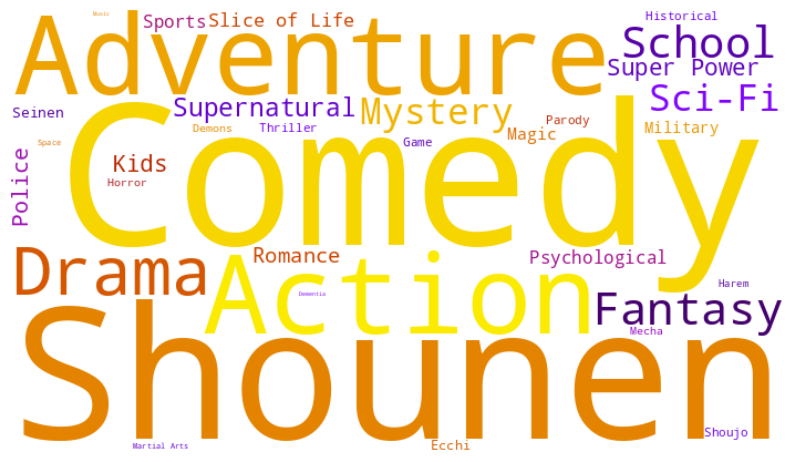

> animes highly rated by this user


,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
14963,Attack on Titan Season 3 Part 2,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
9886,A Silent Voice,"Drama, School, Shounen"
11308,Your Name.,"Romance, Supernatural, School, Drama"


In [46]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(5)

##

In [47]:
def get_recommended_animes(similar_users, n=10):
    recommended_animes = []  # 추천 애니메이션을 저장할 리스트 초기화
    anime_list = []  # 각 사용자의 선호 애니메이션을 저장할 리스트 초기화

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), verbose=0)  # 사용자의 선호 애니메이션 리스트를 가져옴
        pref_list = pref_list[~ pref_list.eng_version.isin(user_pref.eng_version.values)]  # 사용자의 선호 애니메이션 중 이미 본 애니메이션을 제외
        anime_list.append(pref_list.eng_version.values)  # 선호 애니메이션을 리스트에 추가

    anime_list = pd.DataFrame(anime_list)  # 리스트를 데이터프레임으로 변환
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    # 데이터프레임을 평탄화하고, 애니메이션의 빈도수를 세어 상위 n개의 애니메이션을 선택

    for i, anime_name in enumerate(sorted_list.index):
        n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]  # 해당 애니메이션을 선호하는 사용자 수를 가져옴
        if isinstance(anime_name, str):
            try:
                frame = getAnimeFrame(anime_name)  # 애니메이션 프레임 정보를 가져옴
                anime_id = frame.anime_id.values[0]  # 애니메이션 ID를 가져옴
                genre = frame.Genres.values[0]  # 애니메이션 장르를 가져옴
                sypnopsis = getSypnopsis(int(anime_id))  # 애니메이션 시놉시스를 가져옴
                recommended_animes.append({  # 추천 애니메이션 리스트에 추가
                    "n": n_user_pref,  # 해당 애니메이션을 선호하는 사용자 수
                    "anime_name": anime_name,  # 애니메이션 이름
                    "Genres": genre,  # 애니메이션 장르
                    "sypnopsis": sypnopsis  # 애니메이션 시놉시스
                })
            except:
                pass  # 예외 발생 시 아무 것도 하지 않음

    return pd.DataFrame(recommended_animes)  # 추천 애니메이션 리스트를 데이터프레임으로 반환


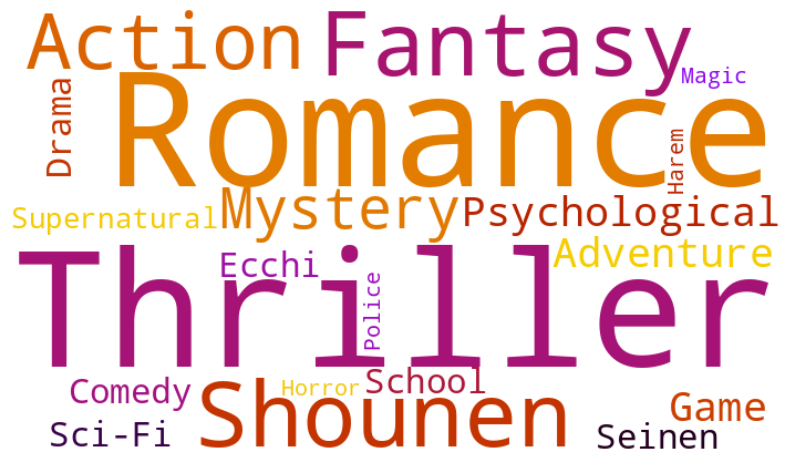


> Top recommendations for user: 73178


,n,anime_name,Genres,sypnopsis
0,2,Monster,"Drama, Horror, Mystery, Police, Psychological, Seinen, Thriller","Dr. Kenzou Tenma, an elite neurosurgeon recently engaged to his hospital director's daughter, is well on his way to ascending the hospital hierarchy. That is until one night, a seemingly small event changes Dr. Tenma's life forever. While preparing to perform surgery on someone, he gets a call from the hospital director telling him to switch patients and instead perform life-saving brain surgery on a famous performer. His fellow doctors, fiancée, and the hospital director applaud his accomplishment; but because of the switch, a poor immigrant worker is dead, causing Dr. Tenma to have a crisis of conscience. So when a similar situation arises, Dr. Tenma stands his ground and chooses to perform surgery on the young boy Johan Liebert instead of the town's mayor. Unfortunately, this choice leads to serious ramifications for Dr. Tenma—losing his social standing being one of them. However, with the mysterious death of the director and two other doctors, Dr. Tenma's position is restored. With no evidence to convict him, he is released and goes on to attain the position of hospital director. Nine years later when Dr. Tenma saves the life of a criminal, his past comes back to haunt him—once again, he comes face to face with the monster he operated on. He must now embark on a quest of pursuit to make amends for the havoc spread by the one he saved."
1,2,Steins;Gate,"Thriller, Sci-Fi","The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective ""future gadgets"" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed ""Daru."" The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the ""Phone Microwave,"" which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn't provide anything concrete in Okabe's search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory and practicality. Forced across the diverging threads of past and present, Okabe must shoulder the burdens that come with holding the key to the realm of time."
2,2,Prison School,"Comedy, Ecchi, Romance, School, Seinen","ocated on the outskirts of Tokyo, Hachimitsu Private Academy is a prestigious all-girls boarding school, famous for its high-quality education and disciplined students. However, this is all about to change due to the revision of the school's most iconic policy, as boys are now able to enroll as well. At the start of the first semester under this new decree, a mere five boys have been accepted, effectively splitting the student body into a ratio of two hundred girls to one boy. Kiyoshi, Gakuto, Shingo, Andre, and Jo are quickly cast away without having a chance to make any kind of a first impression. Unable to communicate with their fellow female students, the eager boys set their sights on a far more dangerous task: peeping into the girls' bath! It's only after their plan is thoroughly decimated by the infamous Underground Student Council that the motley crew find their freedom abruptly taken from them, as they are thrown into the school's prison with the sentence of an entire month as punishment. Thus begins the tale of the boys' harsh lives in Prison School, a righteous struggle that will ultimately test the bonds of friendship and perverted brotherhood."
3,2,Death Parade,"Game, Mystery, Psychological, Drama, Thriller","fter death, there is no he

In [48]:
recommended_animes = get_recommended_animes(similar_users, n=10)
getFavGenre(recommended_animes, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_animes

In [49]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

animes_watched_by_user = rating_df[rating_df.user_id==random_user]
anime_not_watched_df = df_anime[
    ~df_anime["anime_id"].isin(animes_watched_by_user.anime_id.values)
]

anime_not_watched = list(
    set(anime_not_watched_df['anime_id']).intersection(set(anime2anime_encoded.keys()))
)

anime_not_watched = [[anime2anime_encoded.get(x)] for x in anime_not_watched]

user_encoder = user2user_encoded.get(random_user)

user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

user_anime_array = [user_anime_array[:, 0], user_anime_array[:, 1]]
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_anime_ids = [
    anime_encoded2anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, anime_id in enumerate(anime_not_watched):
    rating = ratings[index]
    id_ = anime_encoded2anime.get(anime_id[0])

    if id_ in recommended_anime_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df_anime.anime_id == id_)
            name = df_anime[condition]['eng_version'].values[0]
            genre = df_anime[condition].Genres.values[0]
            score = df_anime[condition].Score.values[0]
            sypnopsis = getSypnopsis(int(id_))
        except:
            continue

        Results.append({#"anime_id": id_,
                        "name": name,
                        "pred_rating": rating,
                        "genre": genre,
                        'sypnopsis': sypnopsis})

print("---" * 25)
print("> Top 10 anime recommendations")
print("---" * 25)


Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
Results


Showing recommendations for user: 73178
521/521 [==============================] - 2s 4ms/step
---------------------------------------------------------------------------
> Top 10 anime recommendations
---------------------------------------------------------------------------


,name,pred_rating,genre,sypnopsis
3,The Secret About That Girl,0.944958,"Music, Romance","original song by Eve, sung by Hatsune Miku, animated by Okamoto and TriF Studio. Eve's self-cover uses the same animated footage and was released on July 15, 2017. Eve included his self-cover MV on his own self-made record label harapeco records 's CD+DVD release on December 13, 2017 as a part of his ""Bunka"" album."
4,Tsubasa RESERVoir CHRoNiCLE:Spring Thunder Chronicle,0.940171,"Action, Adventure, Mystery, Supernatural, Drama, Magic, Romance, Fantasy, Shounen","Tsubasa/xxxHOLiC Project A 4 part OVA released with the limited editions of the Tsubasa and xxxHOLiC volumes. There are two OVAs for each series, with plots linked together. They cover the Nihon Country Arc and scarcely some of the Celes Country Arc. (Source: Official Project Website)"
9,Kono Sekai no Tanoshimikata: Secret Story Film,0.933335,Music,"anime movie based on HoneyWorks' LIPxLIP virtual idol unit, commemorating the music circle's 10th anniversary. (Source: MAL News)"
7,Persona 5 the Animation Specials,0.931133,"Slice of Life, Comedy","Unaired episodes included in 11th & 12th BD/DVD volume of the Persona 5 the Animation . These volumes contained the two Persona 5 the Animation TV Specials (""Stars and Ours"" & ""Dark Sun..."" respectively) rather than episodes of the regular TV series. #1: Few days after battle against Akechi. Ren, who was helping out with the cafe, saw a cross word puzzle magazine on the table and saw Akechi's handwriting besides a solved crossword ""Seigi no Akashi (Sign of Justice)."" In order to investigate the meaning, he walks around the street under the cold winter snow while thinking back at the memory with Akechi. The meaning that revealed and Akechi's feeling is... #2: Valentine's Day Omnibus Story featuring Ren Amamiya."
2,Code Geass:Lelouch of the Rebellion R2,0.928473,"Action, Military, Sci-Fi, Super Power, Drama, Mecha","One year has passed since the Black Rebellion, a failed uprising against the Holy Britannian Empire led by the masked vigilante Zero, who is now missing. At a loss without their revolutionary leader, Area 11's resistance group—the Black Knights—find themselves too powerless to combat the brutality inflicted upon the Elevens by Britannia, which has increased significantly in order to crush any hope of a future revolt. Lelouch Lamperouge, having lost all memory of his double life, is living peacefully alongside his friends as a high school student at Ashford Academy. His former partner C.C., unable to accept this turn of events, takes it upon herself to remind him of his past purpose, hoping that the mastermind Zero will rise once again to finish what he started, in this thrilling conclusion to the series."
1,Tsubasa RESERVoir CHRoNiCLE:Tokyo Revelations,0.927908,"Action, Adventure, Drama, Romance, Fantasy, Shounen","Continuing their journey from Record Country (the place that held the book of memories), Syaoran and company land into Tokyo Country, a blood-filled country under war from opposing factions for natural resources and survival. While reluctantly involved in the race to live, the group faces their own problems as certain revelations are made, changing their journey forever. A shocking betrayal and a battle that risks all of their lives. After this revelation, they will never be the same again."
6,Gintama: The Final,0.923096,"Action, Sci-Fi, Comedy, Historical, Parody, Drama, Samurai, Shounen",New Gintama movie.
8,Mazinkaiser SKL,0.919633,"Adventure, Comedy, Mecha, Sci-Fi, Shounen","Prior to the events of the anime, three factions—the Garan Army, the Kiba Army, and the Aira Army, battle for total dominance of Machine Island. The island is basically a prison, isolated from the rest of the world. The island contains a vast amount of resources, allowing the three factions to create an infinite supply of giant robots for their respective armies. The world government learns that the island's power reactor has become uns

In [50]:
# model.save('anime_model.h5')

# from IPython.display import FileLink
# FileLink(r'./anime_model.h5')